In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from bilby.gw.conversion import total_mass_and_mass_ratio_to_component_masses, bilby_to_lalsimulation_spins as spin_convert
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [70]:
# Generate a precessing waveform
def gen_prec_wf(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096):

    # Convert parameters
    mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = spin_convert(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, mass_1, mass_2, f_low, phase)

    # Generate waveform
    hp, hc = get_td_waveform(approximant='IMRPhenomXPHM', 
                             mass1=mass_1,
                             mass2=mass_2,
                             f_lower=f_low,
                             delta_t=1/sample_rate,
                             inclination=iota,
                             spin1x=spin_1x,
                             spin1y=spin_1y,
                             spin1z=spin_1z,
                             spin2x=spin_2x,
                             spin2y=spin_2y,
                             spin2z=spin_2z,
                             coa_phase=phase)

    return hp - 1j*hc

In [124]:
# Make precessing harmonics
def gen_prec_harms(f_low, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096):

    # _0 harmonics

    # Generate constituent waveforms
    x_0_0_0_0 = gen_prec_wf(f_low, M, q, 0, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_0_0_pi4_pi4 = gen_prec_wf(f_low, M, q, 0, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_0_pi4_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_pi2_0_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_0_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_pi2_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()

    # Above uses six waveforms - can this be simplified to five?

    # Combine to make _0 harmonics
    h_0_0 = (1/2)*(x_0_0_0_0-x_0_0_pi4_pi4)
    h_0_4 = (1/2)*(x_0_0_0_0+x_0_0_pi4_pi4)
    h_0_1 = -(1/4)*(x_pi2_0_pi4_pi4+x_pi2_pi2_0_pi4)
    h_0_3 = -(1/4)*(x_pi2_0_pi4_pi4-x_pi2_pi2_0_pi4)
    h_0_2 = (1/6)*(x_pi2_0_0_0+x_pi2_pi2_0_0)

    # _pi/2 harmonics

    # Generate consistuent waveforms
    x_0_0_0_pi4 = gen_prec_wf(f_low, M, q, 0, 0, 0, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_0_0_pi4_0 = gen_prec_wf(f_low, M, q, 0, 0, np.pi/4, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_0_0_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, 0, 0, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_pi2_pi4_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_0_pi4_0 = gen_prec_wf(f_low, M, q, np.pi/2, 0, np.pi/4, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()
    x_pi2_pi2_pi4_0 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, np.pi/4, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate).real()

    # Combine to make _1 harmonics
    h_pi2_0 = -(1/2)*(x_0_0_0_pi4+x_0_0_pi4_0)
    h_pi2_4 = (1/2)*(x_0_0_0_pi4-x_0_0_pi4_0)
    h_pi2_1 = -(1/4)*(x_pi2_0_0_pi4-x_pi2_pi2_pi4_pi4)
    h_pi2_3 = -(1/4)*(x_pi2_0_0_pi4+x_pi2_pi2_pi4_pi4)
    h_pi2_2 = -(1/6)*(x_pi2_0_pi4_0+x_pi2_pi2_pi4_0)

    return h_0_0+1j*h_pi2_0, h_0_1+1j*h_pi2_1, h_0_2+1j*h_pi2_2, h_0_3+1j*h_pi2_3, h_0_4+1j*h_pi2_4

In [125]:
h = gen_prec_wf(10, 30, 2, 0, 0, 0, 0, np.pi/2, np.pi/2, np.pi/2, 0.7, 0)
harms = gen_prec_harms(10, 30, 2, np.pi/2, np.pi/2, np.pi/2, 0.7, 0)

(-7.5, 1.0)

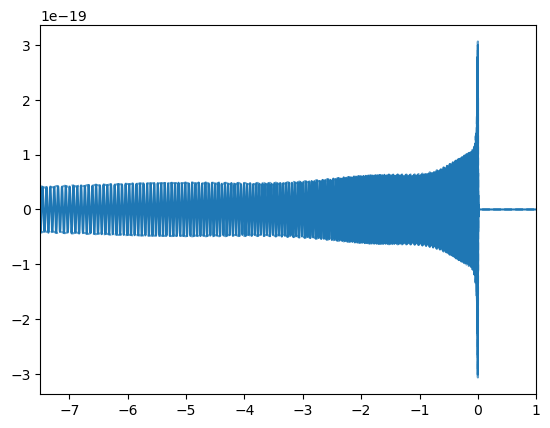

In [126]:
plt.plot(h.sample_times, h, c='C0')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.7)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.7)
plt.xlim(-7.5, 1)
# plt.ylim(-1.5e-19, 1.5e-19)

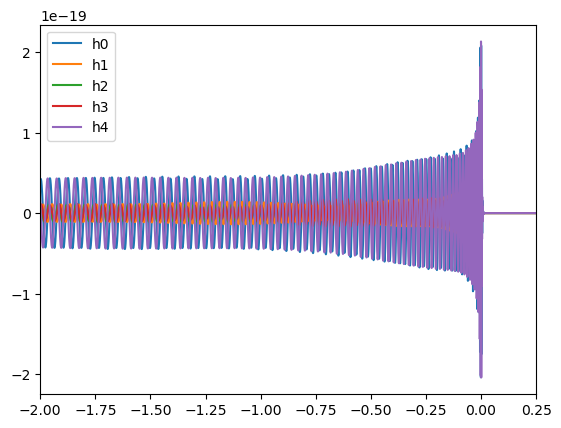

In [127]:
for i, harm in enumerate(harms):
    plt.plot(harm.sample_times, harm, c=f'C{i}', label=f'h{i}')
    # plt.plot(harm.sample_times, np.abs(harm), c=f'C{i}', ls='dashed', alpha=0.7, label=f'h{i}')
    # plt.plot(harm.sample_times, -np.abs(harm), c=f'C{i}', ls='dashed', alpha=0.7)
plt.xlim(-2, 0.25)
#plt.ylim(-1e-19, 1e-19)
plt.legend()

In [128]:
for i in range(len(harms)):
    for j in range(i+1):
        print(i, j, np.abs(overlap_cplx_wfs(harms[i], harms[j], 10, f_match=20, normalized=True)))
    print('\n')

0 0 0.9999999999999999


1 0 0.9479394055793223
1 1 0.9999999999999999


2 0 0.9880296921251601
2 1 0.9517965898718568
2 2 0.9999999999999999


3 0 0.9430160571048792
3 1 0.8271783449528975
3 2 0.9551502386482076
3 3 0.9999999999999999


4 0 0.9990206696191484
4 1 0.9487987557761883
4 2 0.9874896617292888
4 3 0.9417160717571462
4 4 1.0


